# 📈 💸 Time Series

## ℹ️ Readme

* ✍️ This challenge was written by [davydw](https://github.com/davydw)
* 🎯 The goal is to predict Apple Stock Price in the future using <font color="red">AR</font><font color="green">I</font><font color="blue">MA</font> model
* 🚓 It is designed only for students of `Le Wagon - Batch 1538 - Barcelona` and cannot be reproduced without davydw's authorization. Indeed, he is no longer working as a full time employee at Le Wagon. Hence, the latter cannot claim and publish this recap on their learning platform `Kitt` without his consent.


## 📚 Libraries

🎁 We have already imported all the functions you need from `statsmodels` and `pmdarima` here!

In [249]:
# DATA MANIPULATION
import pandas as pd
import numpy as np
import datetime

# DATA VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns

# STATSMODELS = TIME SERIES ANALYSIS
## DECOMPOSITION
from statsmodels.tsa.seasonal import seasonal_decompose
## STATIONARITY ANALYSIS - HOW MANY ORDERS OF DIFFERENCING
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
## ACF AND PACF
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
## ARIMA / SARIMA
from statsmodels.tsa.arima.model import ARIMA
## STATS GRIDSEARCH
import pmdarima as pm
## PLOT PREDICTION
from statsmodels.graphics.tsaplots import plot_predict

## ⚒️ Utils

🎁 You will need this function during Section **(5) <font color="orange">FORECAST</font>**

In [250]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);


## 👨🏻‍🏫 Box Jenkins Method

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/lectures/machine-learning/time_serie_process_overview.jpg">

## (0) VISUALIZE

### (0.1) `AAPL` (1985-2023)

📈 [Apple Stock Price since 1985](https://finance.yahoo.com/quote/AAPL/history?period1=345427200&period2=1677715200&interval=1mo&filter=history&frequency=1mo&includeAdjustedClose=true) - *Source: Yahoo Finance*

<img src="https://github.com/davydw/public-pictures/blob/main/data-illustrations/yahoo_finance_tuto_aapl_stock_price.png?raw=true" height = 200 width = 600 align = "left">

❓ ***Getting the data***
1. Go to Yahoo Finance
2. Search for AAPL
3. Download the historical data (monthly)
4. How many rows? What types of columns?

❓ Convert the `Date` column into a `datetime` format and use it as the index of your DataFrame

👉 Let's focus on the `Close` values

<details>
    <summary><i>Hint</i></summary>

* <a href="https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html">pandas.to_datetime</a>
    * <i>infer_datetime_format</i>
        
</details>
        


In [251]:
data = pd.read_csv("AAPL_monthly_yahoo_1985_2023.csv", parse_dates=["Date"])
data.set_index("Date", inplace=True);

In [252]:
data.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1985-01-01,0.130022,0.138951,0.124442,0.129464,0.100589,6366416000
1985-02-01,0.129464,0.137277,0.110491,0.110491,0.085847,4733388800


### (0.2) First glimpse

❓ ***Plot the Time Series***

<AxesSubplot:xlabel='Date', ylabel='Close'>

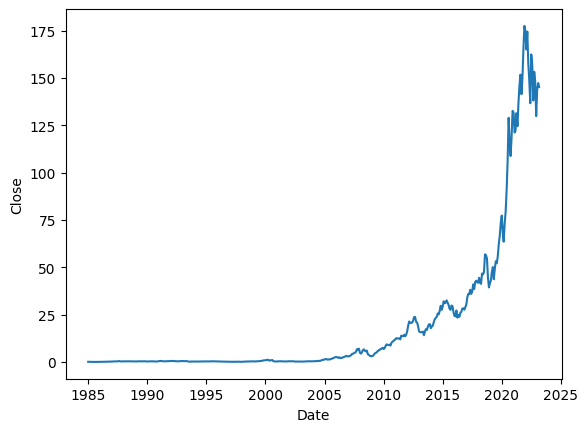

In [253]:
sns.lineplot(x=data.index, y=data["Close"])

### (0.3) Linearizing

❓ What function could you use to linearize this Time Series? Linearize it.

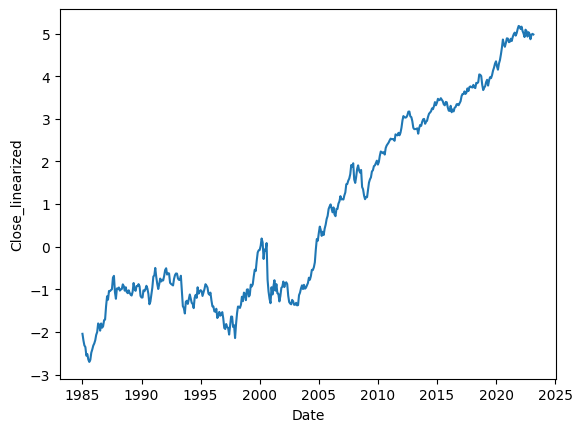

In [254]:
data['Close_linearized'] = np.log(data['Close'])
sns.lineplot(x=data.index, y=data["Close_linearized"]);

❓ Plot side-by-side the original TimeSeries and the Linearized Series

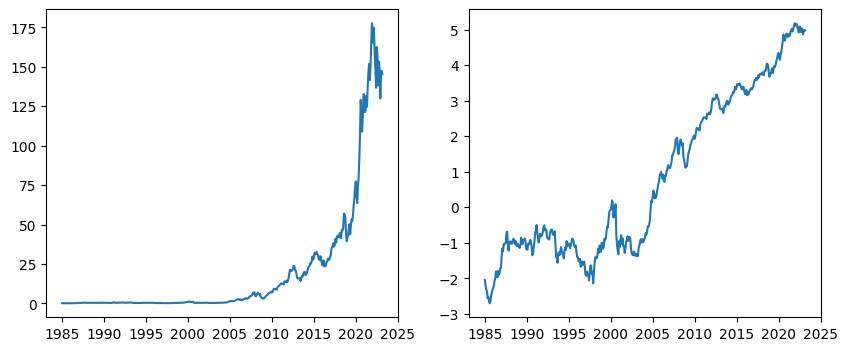

In [255]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axs[0].plot(data.index, data["Close"])
axs[1].plot(data.index, data["Close_linearized"])

👆 **Warnings**

* Time Series with negative values can't be decomposed multiplicatively...
* Apple stock price started skyrocketing after 2009...
* If you read a bit about Financial News, Apple proceeded to a stock split:
    - [Investopedia - Stocksplit](https://www.investopedia.com/terms/s/stocksplit.asp)
    - [Forbes 2020/07/31 - Apple announces a 4-for-1 split](https://www.forbes.com/sites/lcarrel/2020/07/31/apple-announces-4-for-1-stock-split-to-bring-in-new-investors/?sh=626f2e755401)

❓ Tmove data before 2020 and use the dates as the indexes of the TimeSeries.

In [ ]:
data_2020_onwards = data.loc[data.index >= "2020-02-01"]

data_2020_onwards.head(5)

,Open,High,Low,Close,Adj Close,Volume,Close_linearized
Date,,,,,,,
2020-01-01,74.059998,81.962502,73.187500,77.377502,75.689423,2934370400,4.348696
2020-02-01,76.074997,81.805000,64.092499,68.339996,66.849098,3019279200,4.224495
2020-03-01,70.570000,76.000000,53.152500,63.572498,62.333183,6280072400,4.152181
2020-04-01,61.625000,73.632500,59.224998,73.449997,72.018127,3265299200,4.296605
2020-05-01,71.562500,81.059998,71.462502,79.485001,77.935471,2805936000,4.375568


In [ ]:
data.shape

(459, 7)

In [ ]:
data_2020_onwards.shape

(39, 7)

## (1) DECOMPOSE

### (1.1) Decomposition the "original" Time Series

❓ Decompose the original Time Series using `seasonal_decompose` additively and multiplicatively.

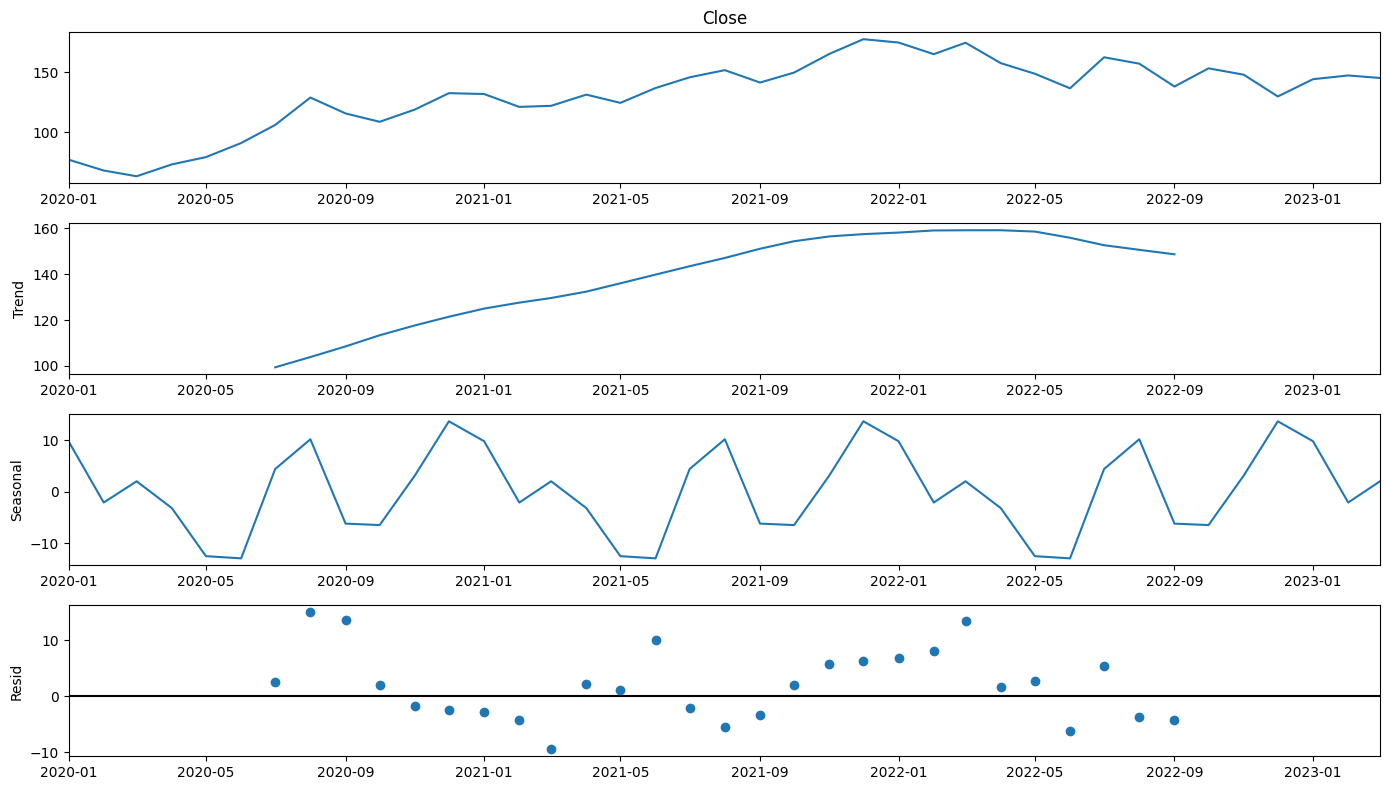

In [259]:
# Additive Decomposition (y = Trend + Seasonal + Residuals)
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(data_2020_onwards['Close'], model='additive')
fig = result_add.plot()
fig.set_size_inches((14, 8))
fig.tight_layout();

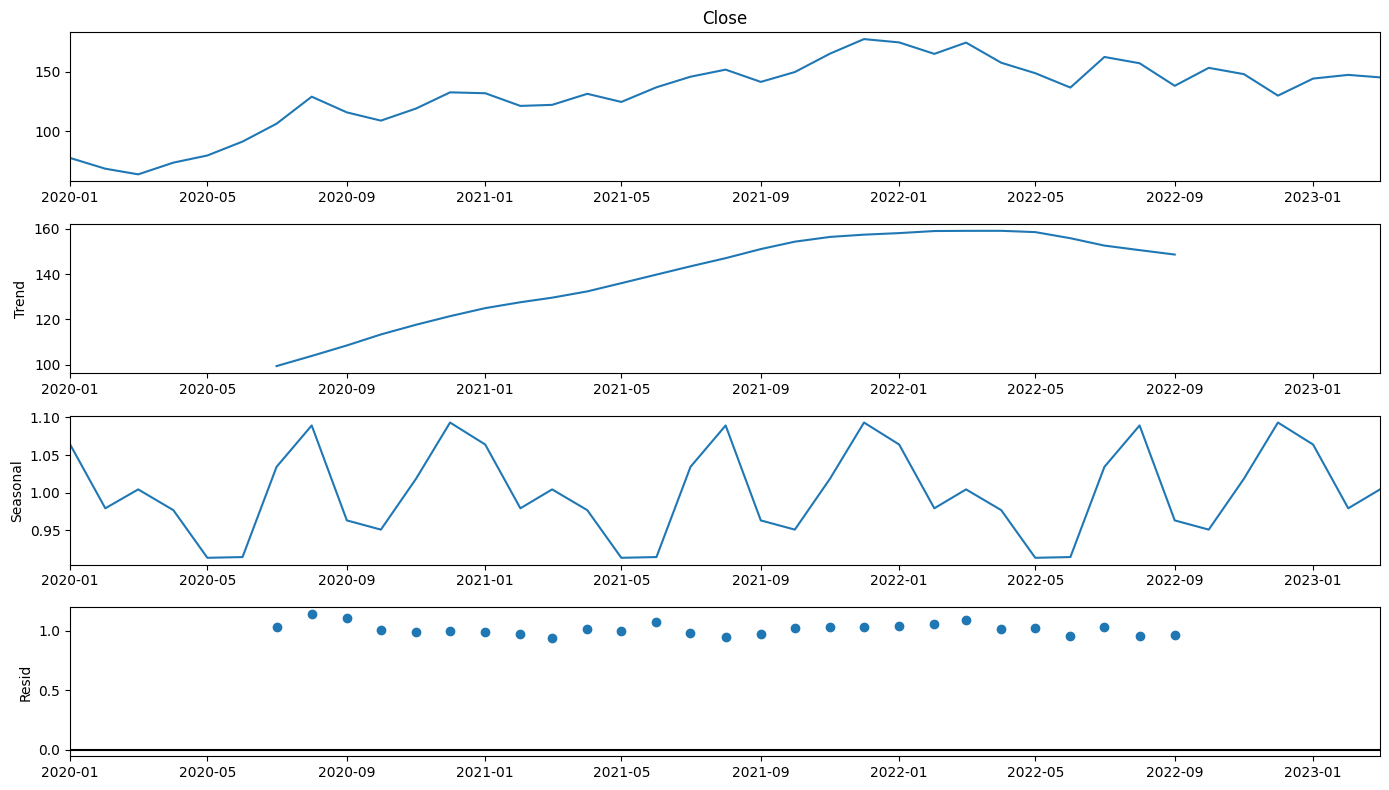

In [260]:
# Multiplicative Decomposition (y = Trend * Seasonal * Residuals)
from statsmodels.tsa.seasonal import seasonal_decompose
result_mult = seasonal_decompose(data_2020_onwards['Close'], model='multiplicative')
fig = result_mult.plot()
fig.set_size_inches((14, 8))
fig.tight_layout();


❓ Choose your favorite decomposition based on the `adfuller` test

In [261]:
from statsmodels.tsa.stattools import adfuller
print('additive resid: ', adfuller(result_add.resid.dropna())[1])
print('multiplicative resid: ', adfuller(result_mult.resid.dropna())[1])

additive resid:  0.180815742861539
multiplicative resid:  0.037534292068809566


In [262]:
# Comparing the ADF tests for both residuals

### (1.2) Decomposition the "logarithmized" Time Series

❗️ Actually, the stock price has been growing exponentially, so we are going to work on the logarithm of the Time Series instead.

❓ Decompose the logarithmized Time Series additively and multiplicatively. Based on the `adfuller` test, which one would you choose ? 

In [263]:
data_2020_onwards['Close_linearized'].head(5)

Date
2020-01-01    4.348696
2020-02-01    4.224495
2020-03-01    4.152181
2020-04-01    4.296605
2020-05-01    4.375568
Name: Close_linearized, dtype: float64

In [264]:
# Additive Decomposition (y = Trend + Seasonal + Residuals)
result_add_lin = seasonal_decompose(data_2020_onwards['Close_linearized'], model='additive')
#fig = result_add_lin.plot()
#fig.set_size_inches((14, 8))
#fig.tight_layout();
print(result_add_lin.resid.dropna()[1])
print(adfuller(result_add_lin.resid.dropna())[1])

0.1549217007926737
0.06650416695715707


In [265]:
# Multiplicative Decomposition (y = Trend * Seasonal * Residuals)
result_mult_lin = seasonal_decompose(data_2020_onwards['Close_linearized'], model='multiplicative')
#fig = result_mult_lin.plot()
#fig.set_size_inches((14, 8))
#fig.tight_layout();
print(result_mult_lin.resid.dropna()[1])
print(adfuller(result_mult_lin.resid.dropna())[1])

1.0333440469119506
0.07168499257335091


❓ Choose your favorite decomposition based on the `adfuller` test

In [266]:
# Comparing the ADF tests for both residuals

In [267]:
print('additive resid: ', adfuller(result_add_lin.resid.dropna())[1])
print('multiplicative resid: ', adfuller(result_mult_lin.resid.dropna())[1])

additive resid:  0.06650416695715707
multiplicative resid:  0.07168499257335091


### (1.3) Remove seasonality

❓ Look at the seasonality of your Time Series. De-seasonlize your Logarithmized Time Series. Compare the latter with the non-deseasonalized Time Series. Do you detect any seasonality?

In [268]:
# Removing the multiplicative seasonal component
data_2020_onwards['Close_lin_deseasonalized'] = data_2020_onwards["Close_linearized"].values/result_mult_lin.seasonal

/tmp/ipykernel_32084/1353652545.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2020_onwards['Close_lin_deseasonalized'] = data_2020_onwards["Close_linearized"].values/result_mult_lin.seasonal


In [269]:
# Having a look at the deseasonalized LogClose vs the LogClose
data_2020_onwards['Close_lin_deseasonalized'].head(5)

Date
2020-01-01    4.296894
2020-02-01    4.245293
2020-03-01    4.153171
2020-04-01    4.318070
2020-05-01    4.457745
Name: Close_lin_deseasonalized, dtype: float64

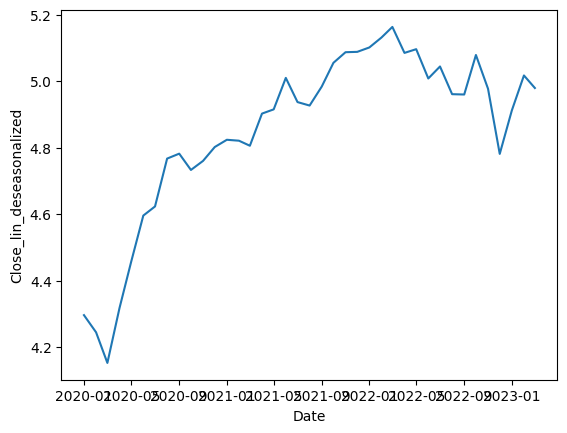

In [270]:
sns.lineplot(x=data_2020_onwards.index, y=data_2020_onwards["Close_lin_deseasonalized"]);

👆 Our intuition is confirmed, there is no seasonality in the historic values of the `AAPL` stock price. But we can still work with the deseasonalized version and re-introduce it during the forecasts.

## (2) STATIONARITY / DIFFERENCING

❓ Differentiate your logarithmized TS once , twice, thrice.

* Try to determine *d* visually
* Then use `nbdiffs` from `pmdarima.arima.utils` to confirm your intuition

In [271]:
# determining d visually

In [272]:
# check with ADF Test for stationarity
print('p-value zero-diff: ', adfuller(data_2020_onwards["Close_lin_deseasonalized"])[1])
print('p-value first-diff: ', adfuller(data_2020_onwards["Close_lin_deseasonalized"].diff().dropna())[1])
print('p-value second-diff: ', adfuller(data_2020_onwards["Close_lin_deseasonalized"].diff().diff().dropna())[1])
print('p-value third-diff: ', adfuller(data_2020_onwards["Close_lin_deseasonalized"].diff().diff().diff().dropna())[1])

p-value zero-diff:  0.2011754633846859
p-value first-diff:  6.54435057802216e-06
p-value second-diff:  8.158742799117915e-06
p-value third-diff:  2.380355568756725e-05


👆 Diffencing $\color{green}{d=1}$ should be enough!

In [273]:
data_2020_onwards["Close_lin_deseason_diff"] = data_2020_onwards["Close_lin_deseasonalized"].diff().dropna()

/tmp/ipykernel_32084/1279474368.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2020_onwards["Close_lin_deseason_diff"] = data_2020_onwards["Close_lin_deseasonalized"].diff().dropna()


## (3) <font color="blue">ACF</font> and <font color="red">PACF</font>

❓ Plot `pacf` (partial autocorrelation function) and `acf` (autocorrelation function)

In [274]:
# LAGS MUST BE LOWER THAN 50% OF THE LEN(DF)
# Use this number of lags for your plots
lags = len(data_2020_onwards)/2-1
lags = 12

/home/branchedelac/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


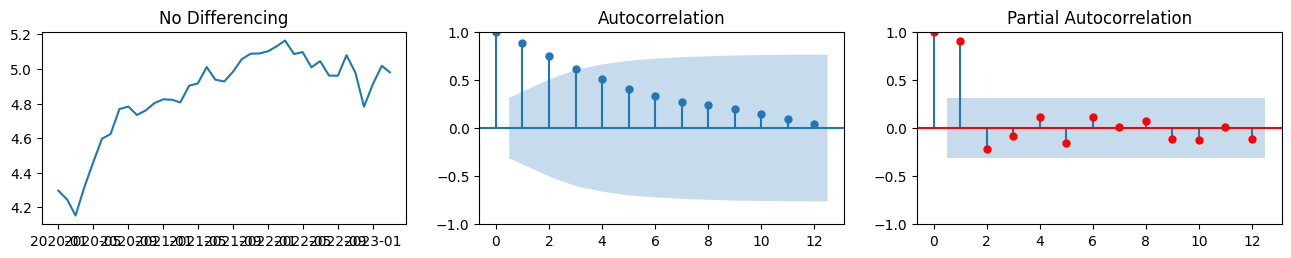

In [275]:
# ACF / PACF analysis of y_diff linearized
fig, axes = plt.subplots(1,3, figsize=(16,2.5))
axes[0].plot(data_2020_onwards["Close_lin_deseasonalized"]); axes[0].set_title('No Differencing')
plot_acf(data_2020_onwards["Close_lin_deseasonalized"], lags=lags, ax=axes[1]);
plot_pacf(data_2020_onwards["Close_lin_deseasonalized"], lags=lags, ax=axes[2], c='r');

❓ For the 1-differenced logarithmized Time Series, plot `pacf` (partial autocorrelation function) and `acf` (autocorrelation function)

/home/branchedelac/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


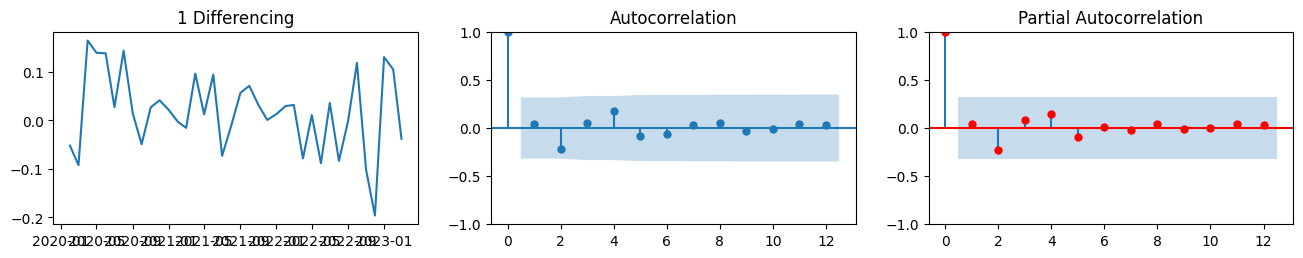

In [276]:
# ACF / PACF analysis of y_diff linearized
fig, axes = plt.subplots(1,3, figsize=(16,2.5))
axes[0].plot(data_2020_onwards["Close_lin_deseasonalized"].diff().dropna()); axes[0].set_title('1 Differencing')
plot_acf(data_2020_onwards["Close_lin_deseasonalized"].diff().dropna(), lags=lags, ax=axes[1]);
plot_pacf(data_2020_onwards["Close_lin_deseasonalized"].diff().dropna(), lags=lags, ax=axes[2], c='r');

❓ For the 2-differenced logarithmized Time Series, plot `pacf` (partial autocorrelation function) and `acf` (autocorrelation function)

/home/branchedelac/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


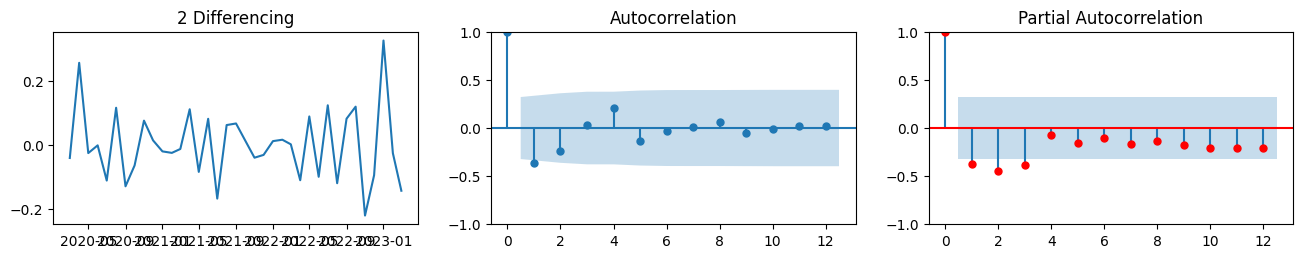

In [277]:
# ACF / PACF analysis of y_diff linearized
fig, axes = plt.subplots(1,3, figsize=(16,2.5))
axes[0].plot(data_2020_onwards["Close_lin_deseasonalized"].diff().diff().dropna()); axes[0].set_title('2 Differencing')
plot_acf(data_2020_onwards["Close_lin_deseasonalized"].diff().diff().dropna(), lags=lags, ax=axes[1]);
plot_pacf(data_2020_onwards["Close_lin_deseasonalized"].diff().diff().dropna(), lags=lags, ax=axes[2], c='r');

## (4) <font color="red">AR</font><font color="green">I</font><font color="blue">MA</font> MODEL

### (4.1) Choosing parameters visually

❓ Choose <font color="red">p</font>, <font color="green">d</font>, <font color="blue">q</font>

In [278]:
p = 1
d = 1
q = 2

### (4.2) Temporal <font color="blue">Train</font>-<font color="orange">Test</font> split

❓ Train Test Split your time Series chronologically.

In [279]:
# Let's keep the last 40% of the values out for testing purposes
train_size = 0.6
index = round(train_size*data_2020_onwards.shape[0])

df_train = data_2020_onwards.iloc[:index]
df_test = data_2020_onwards.iloc[index:]

### (4.3) <font color="blue">Training</font>

❓ Fit an ARIMA model on the train set

In [280]:
arima = ARIMA(df_train["Close_lin_deseasonalized"].dropna(), order=(1, 1, 2), trend='t')
arima = arima.fit()

/home/branchedelac/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/branchedelac/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/branchedelac/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/branchedelac/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary sta

In [281]:
print(arima.summary())

                                  SARIMAX Results                                   
Dep. Variable:     Close_lin_deseasonalized   No. Observations:                   23
Model:                       ARIMA(1, 1, 2)   Log Likelihood                  28.151
Date:                      Thu, 15 Feb 2024   AIC                            -46.302
Time:                              15:11:21   BIC                            -40.846
Sample:                          01-01-2020   HQIC                           -45.017
                               - 11-01-2021                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0353      0.020      1.750      0.080      -0.004       0.075
ar.L1         -0.9996      0.149     -6.700      0.000      -1.292      -0.707
ma.L

## (5) <font color="orange">FORECAST</font>

❗️ Keep in mind that we will have to revert to the "original" Time Series with two steps:
- "re-seasonalize"
- "exponentiate"

In [282]:
import pmdarima as pm
smodel = pm.auto_arima(data_2020_onwards['Close_lin_deseasonalized'].dropna(),
                       start_p=1, max_p=2,
                       start_q=1, max_q=2,
                       trend='t',
                       seasonal=False,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-75.112, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-78.607, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-76.930, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-77.094, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-78.607, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.773 seconds


### (5.1) Forecasting future values for the  "logarithmized" and "deseasonalized" TS

❓ Forecast the future values of the logarithmized+deseasonalized Time Series

Hints:
* `forecast`
* `get_forecast`
* `predicted_mean`

Further hints (optional):
*`conf_int()`

In [283]:
forecast_results = arima.get_forecast(len(df_test))
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values
forecast


2021-12-01    5.148175
2022-01-01    5.163993
2022-02-01    5.218847
2022-03-01    5.234679
2022-04-01    5.289519
2022-05-01    5.305365
2022-06-01    5.360191
2022-07-01    5.376051
2022-08-01    5.430863
2022-09-01    5.446737
2022-10-01    5.501535
2022-11-01    5.517423
2022-12-01    5.572207
2023-01-01    5.588109
2023-02-01    5.642879
2023-03-01    5.658795
Freq: MS, Name: predicted_mean, dtype: float64

### (5.2) Recomposing the original Time Series and the predictions

**Wrap-up**

1. We started from `df["Close"]`
2. Applied the `logarithm` function
3. `Deseasonalized` `df["LogClose"]`

**Reconstruction steps**

Let's reverse-engineer the Time Series

1. Reseasonalize `df["LogClose"]` multiplying by `result_mult_log.seasonal`
2. Apply the `exponential function`

❓ Apply these reconstructions steps to the train set, the test set and the forecasts! (and even the upper and lower bounds of your confidence interval if you want to - *Optional*)

In [284]:
forecast.values

array([5.14817486, 5.16399264, 5.21884693, 5.23467866, 5.289519  ,
       5.30536467, 5.36019108, 5.37605068, 5.43086317, 5.44673668,
       5.50153525, 5.51742268, 5.57220735, 5.58810867, 5.64287945,
       5.65879466])

In [285]:
forecast[:3]

2021-12-01    5.148175
2022-01-01    5.163993
2022-02-01    5.218847
Freq: MS, Name: predicted_mean, dtype: float64

In [286]:
result_mult_lin.seasonal.shape

(39,)

In [287]:
forecast.values.shape

(16,)

In [288]:
## TRAIN RECONSTRUCTED
train_reconstructed = np.exp(df_train["Close_lin_deseasonalized"].values * result_mult_lin.seasonal.iloc[:index])
train_reconstructed

Date
2020-01-01     77.377502
2020-02-01     68.339996
2020-03-01     63.572498
2020-04-01     73.449997
2020-05-01     79.485001
2020-06-01     91.199997
2020-07-01    106.260002
2020-08-01    129.039993
2020-09-01    115.809998
2020-10-01    108.860001
2020-11-01    119.050003
2020-12-01    132.690002
2021-01-01    131.960007
2021-02-01    121.260002
2021-03-01    122.150002
2021-04-01    131.460007
2021-05-01    124.610001
2021-06-01    136.960007
2021-07-01    145.860001
2021-08-01    151.830002
2021-09-01    141.500000
2021-10-01    149.800003
2021-11-01    165.300003
Name: seasonal, dtype: float64

In [289]:
## TEST RECONSTRUCTED
test_reconstructed = np.exp(df_test["Close_lin_deseasonalized"].values * result_mult_lin.seasonal.iloc[index:])
test_reconstructed

Date
2021-12-01    177.570007
2022-01-01    174.779999
2022-02-01    165.119995
2022-03-01    174.610001
2022-04-01    157.649994
2022-05-01    148.839996
2022-06-01    136.720001
2022-07-01    162.509995
2022-08-01    157.220001
2022-09-01    138.199997
2022-10-01    153.339996
2022-11-01    148.029999
2022-12-01    129.929993
2023-01-01    144.289993
2023-02-01    147.410004
2023-03-01    145.309998
Name: seasonal, dtype: float64

In [290]:
# FORECASTED RECONSTRUCTED
reconstructed_forecast = np.exp(forecast.values * result_mult_lin.seasonal.iloc[index:])
reconstructed_forecast

Date
2021-12-01    188.636054
2022-01-01    186.093390
2022-02-01    180.058076
2022-03-01    187.434829
2022-04-01    193.103244
2022-05-01    182.648309
2022-06-01    193.067551
2022-07-01    227.009122
2022-08-01    253.685851
2022-09-01    224.043231
2022-10-01    232.975769
2022-11-01    254.457105
2022-12-01    290.440975
2023-01-01    285.853010
2023-02-01    274.577786
2023-03-01    286.416240
Name: seasonal, dtype: float64

### (5.3) Plots

❓ Finally, use the `plot_forecast` function we gave you 🎉

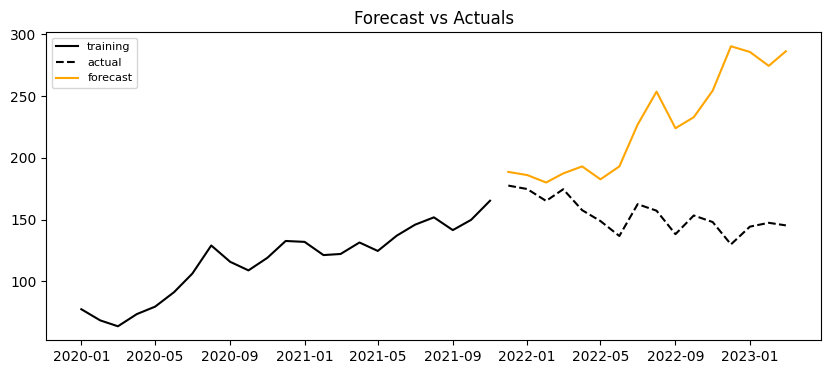

In [291]:
plot_forecast(reconstructed_forecast, train_reconstructed, test_reconstructed)
